<a href="https://colab.research.google.com/github/91htjung/AirportBusinessAnalytics/blob/main/01-Forecast_Longterm_Econometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with Python
Welcome to Airport Business Analytics Course.

In this exercise, we will use Google Colab to run the forecast using Python programming Language.

There are two different exercise, one with a long-term forecast (10 years) using log-log regression model, and the other with a short-term forecast (24 months) using ARIMA model.


1.   01-Forecast_Longterm_Econometric
2.   02-Forecast_Shortterm_Statistics

Before moving on, please read the following "Getting started" block for generic introduction of Google Colab.

# Getting started
The document you are reading is not a static web page, but an interactive environment called a Colab notebook that lets you write and execute code.

For example, here is a code cell with a short Python script that computes a value, stores it in a variable, and prints the result:

In [121]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [122]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

# In this module you will learn how to:

1.   Interact with Pandas library, reading and transforming the dataset
2.   Split our data into train-test samples
3.   Train a linear regression model and test the result
4.   Perform a 10-years forecast using the trained model.


# Setting up the environment

To perform forecasting in Python, we will need to install packages - a collection of Python modules, functions, classes, and variables that can be utilized in other Python programs. Packages provide a structured way to organize and distribute Python code, making it easier for developers to manage and reuse code across different projects.

Here, simply run the cell below by using the keyboard "Ctrl+Enter". The code will be executed and necessary packages will be installed.

In [4]:
import pandas as pd
import numpy as np
import warnings

try:
    import sktime
    import sklearn
    import seaborn as sns
except:
    %pip install sktime
    %pip install sklearn
    %pip install seaborn
    %pip install prophet
    import sktime
    import sklearn
    import seaborn as sns

sns.set(rc={'figure.figsize':(12,4)})
warnings.filterwarnings("ignore")

In this exercise, we will use scikit-learn (sklearn) and sktime library to perform forecasting.

# Reading data

Let's read a dummy data. The dataset can be read by the code below. Similarly, use keyboard "Ctrl+Enter" to run the cell below.

In [115]:
dataset = pd.read_csv('https://raw.githubusercontent.com/91htjung/AirportBusinessAnalytics/main/Data_Longterm_Econometric.csv')
dataset['Period'] = pd.to_datetime(dataset['Period'])
dataset = dataset.set_index(['Period']).to_period("A")
dataset

,Passenger,GDP,Population
Period,,,
2006,4.560756e+09,60994370,6611696
2007,4.908389e+09,63571790,6693580
2008,4.923149e+09,64786270,6776098
2009,4.832530e+09,63629480,6858496
2010,5.282775e+09,66415110,6941248
2011,5.654991e+09,68548300,7024048
2012,5.991817e+09,70249140,7108029
2013,6.392540e+09,72079680,7193107
2014,6.778575e+09,74103710,7278136


The dataset is made up with historic annual Passenger, GDP, and Population statistics:

1.   **Historic** Passenger (2006 - 2019)
2.   **Historic** GDP (2006 - 2019)
3.   **Historic** Population (2006 - 2019)

And forecasted GDP and Population statistics.

4.   **Forecast** GDP (2020 - 2033)
5.   **Forecast** Population (2020 - 2033)

Our goal is to perform the forecast of passenger number between 2020-2033, using the historical passenger traffic and forecasted GDP and Population statistics.

In this context, we are performing a multivariate forecast using GDP and Population as **exogenous variables**. The passenger number is called **endogenous variables**.

# Visualizing data

A great way to begin our examination of the truth would be to visualize the relationship through a chart. We will use seperate line charts to visualize each variables.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Population'>)

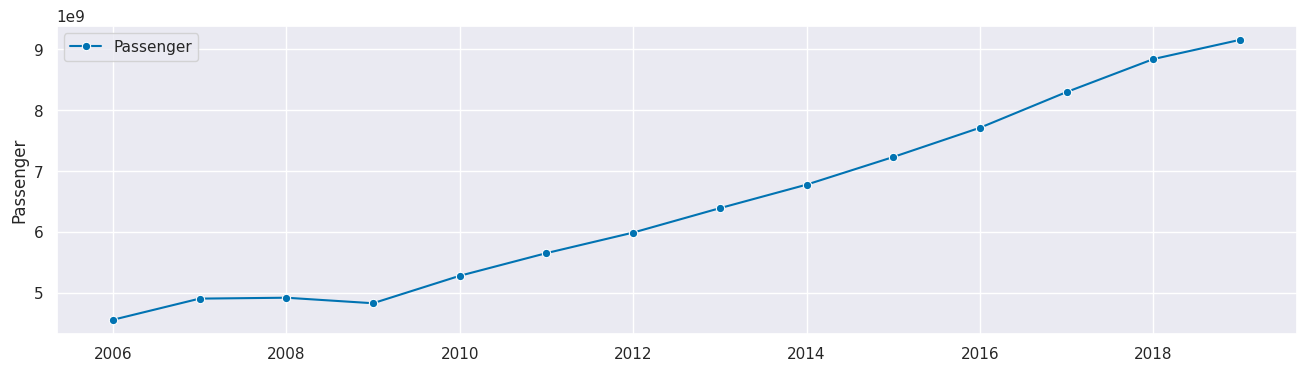

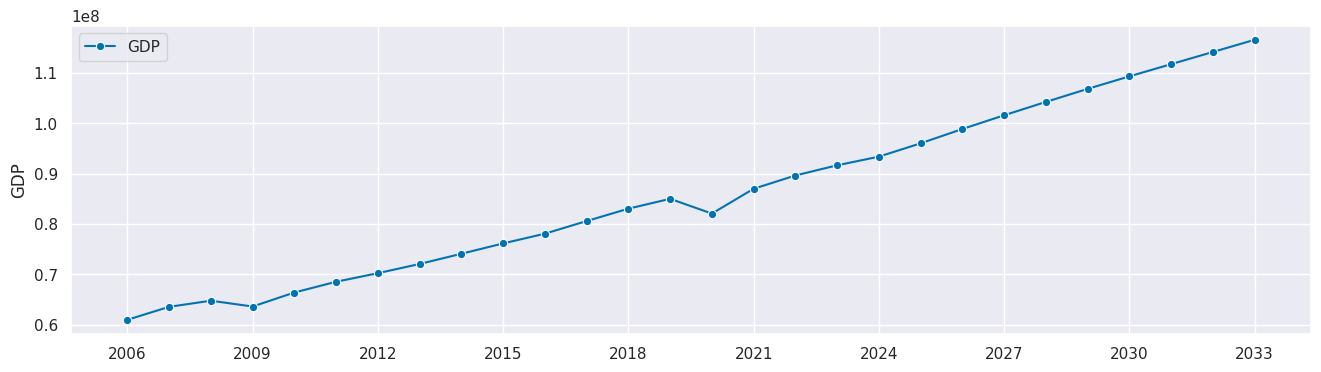

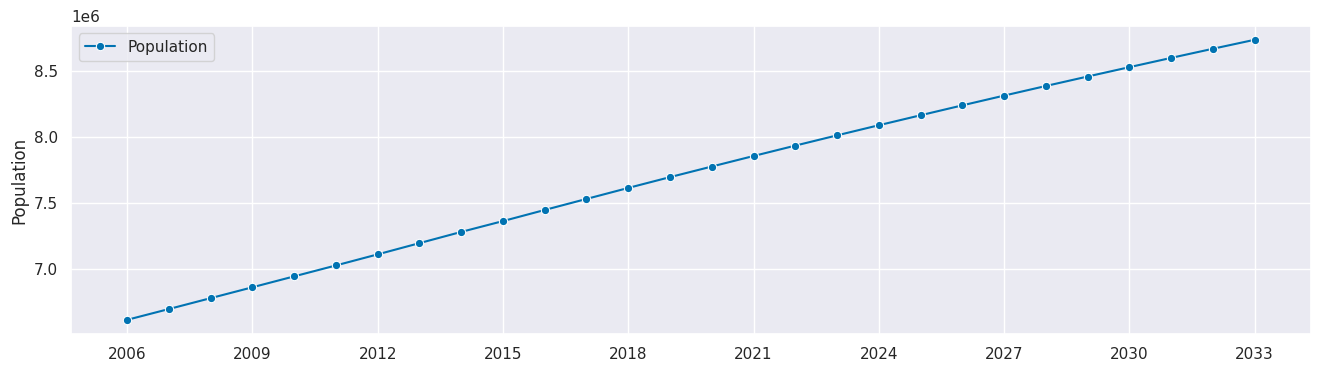

In [6]:
from sktime.utils.plotting import plot_series

plot_series(dataset['Passenger'], labels=['Passenger'])
plot_series(dataset['GDP'], labels=['GDP'])
plot_series(dataset['Population'], labels=['Population'])

# Log transformation

Let's assume that we are going to use the **log-log model** - which is one of the most widely-used model in economic analyses. The detailed explanation of log-log model, please review the materials in **Module 4**.

Before training the linear regression, we need to transform each variables into log. The cell below is the transformation process. We will add new columns of log-transformed variables ("Passenger_log", "GDP_log", and "Population_log").

In [8]:
dataset['Passenger_log'] = np.log(dataset['Passenger'])
dataset['GDP_log'] = np.log(dataset['GDP'])
dataset['Population_log'] = np.log(dataset['Population'])
dataset

,Passenger,GDP,Population,Passenger_log,GDP_log,Population_log
2006,4.560756e+09,60994370,6611696,22.240754,17.926292,15.704351
2007,4.908389e+09,63571790,6693580,22.314212,17.967680,15.716659
2008,4.923149e+09,64786270,6776098,22.317214,17.986604,15.728912
2009,4.832530e+09,63629480,6858496,22.298636,17.968587,15.740999
2010,5.282775e+09,66415110,6941248,22.387717,18.011435,15.752992
2011,5.654991e+09,68548300,7024048,22.455804,18.043049,15.764850
2012,5.991817e+09,70249140,7108029,22.513661,18.067559,15.776736
2013,6.392540e+09,72079680,7193107,22.578397,18.093283,15.788634
2014,6.778575e+09,74103710,7278136,22.637033,18.120976,15.800385
2015,7.232229e+09,76159300,7360282,22.701813,18.148338,15.811609


# Separation of Historic and Forecast section

Since the provided time-seris dataset has both historic data (2006 - 2019) and forecasted data (2020 - 2033), we will separate them into two groups.

The historic data will be used in fitting the forecasting model and the forecast data will be used in generating passenger number forecast from the fitted model.

In [117]:
historic = dataset[(dataset.index <= pd.Period('2019-12-01', freq='A'))]
forecast = dataset[(dataset.index > pd.Period('2019-12-01', freq='A'))]

In [118]:
historic

,Passenger,GDP,Population
Period,,,
2006,4.560756e+09,60994370,6611696
2007,4.908389e+09,63571790,6693580
2008,4.923149e+09,64786270,6776098
2009,4.832530e+09,63629480,6858496
2010,5.282775e+09,66415110,6941248
2011,5.654991e+09,68548300,7024048
2012,5.991817e+09,70249140,7108029
2013,6.392540e+09,72079680,7193107
2014,6.778575e+09,74103710,7278136


In [119]:
forecast

,Passenger,GDP,Population
Period,,,
2020,NaN,82084330,7773787
2021,NaN,87006610,7853534
2022,NaN,89641680,7932355
2023,NaN,91669540,8010128
2024,NaN,93382260,8086800
2025,NaN,96030220,8162399
2026,NaN,98872030,8237484
2027,NaN,101601800,8311435
2028,NaN,104249300,8384303


# Training and test data splitting

Remember that when we are using data-driven techniques, we need to split our sample into a training/test set.

*   **Training set**: subset of the data used to develop models (learn)
*   **Test set**: subset of the data used to test the models (ensure you learned the right thing)

Here, we will use 75% and 25% to split the model without shuffling, so that the later 4 years will be used as a testing dataset.

In [120]:
from sklearn.model_selection import train_test_split

y = pd.DataFrame(historic[['Passenger_log']])
X = historic[['GDP_log', 'Population_log']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.25)


KeyError: "None of [Index(['Passenger_log'], dtype='object')] are in the [columns]"

In [19]:
y_test

,Passenger_log
2016,22.766103
2017,22.839384
2018,22.902495
2019,22.937582


In [21]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['2016', '2017', '2018', '2019'], dtype='period[A-DEC]', is_relative=False)

In [95]:
from sklearn.linear_model import LinearRegression
from sktime.forecasting.compose import make_reduction

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=7, strategy="recursive")

In [96]:
# Fit and predict
forecaster.fit(X=X_train, y=y_train)
y_pred = forecaster.predict(fh, X=X_test)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

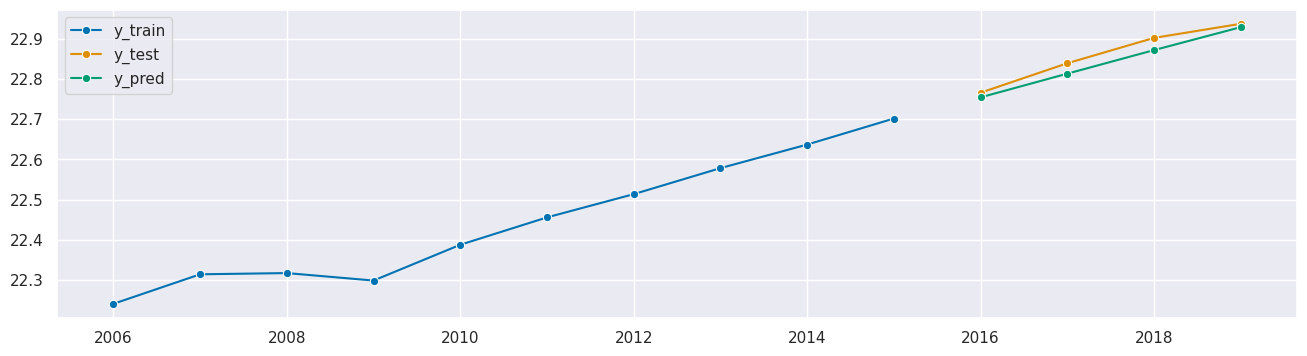

In [97]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [98]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

MAPE: 0.0008


In [99]:
X2 = forecast[['GDP_log', 'Population_log']]
fh2 = ForecastingHorizon(X2.index, is_relative=False)
fh2

ForecastingHorizon(['2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027',
             '2028', '2029', '2030', '2031', '2032', '2033'],
            dtype='period[A-DEC]', is_relative=False)

In [100]:
y2_pred = forecaster.predict(fh2, X=X2)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

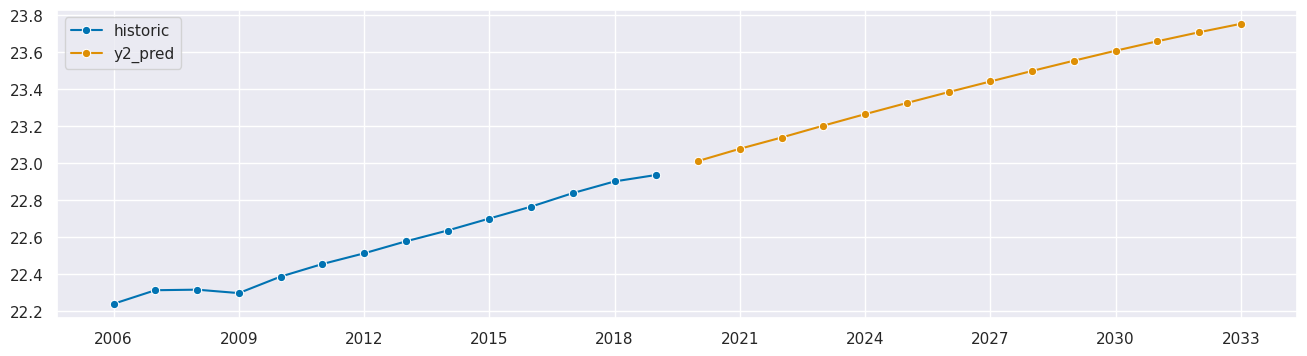

In [101]:
plot_series(y, y2_pred, labels=["historic", "y2_pred"])